<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Part-A---MLP-Coursework-2" data-toc-modified-id="Part-A---MLP-Coursework-2-1">Part A - MLP Coursework 2</a></span><ul class="toc-item"><li><span><a href="#A1-::-Baseline-Experimens-using-DNN-on-EMNIST" data-toc-modified-id="A1-::-Baseline-Experimens-using-DNN-on-EMNIST-1.1">A1 :: Baseline Experimens using DNN on EMNIST</a></span><ul class="toc-item"><li><span><a href="#Experiment-1:-Changing-number-of-hidden-layers-(2-10)" data-toc-modified-id="Experiment-1:-Changing-number-of-hidden-layers-(2-10)-1.1.1">Experiment 1: Changing number of hidden layers (2-10)</a></span><ul class="toc-item"><li><span><a href="#RELU-Layer" data-toc-modified-id="RELU-Layer-1.1.1.1">RELU Layer</a></span></li><li><span><a href="#Sigmoid-Layer" data-toc-modified-id="Sigmoid-Layer-1.1.1.2">Sigmoid Layer</a></span></li><li><span><a href="#ELU-Layer" data-toc-modified-id="ELU-Layer-1.1.1.3">ELU Layer</a></span></li><li><span><a href="#SELU-Layer" data-toc-modified-id="SELU-Layer-1.1.1.4">SELU Layer</a></span></li><li><span><a href="#Maxout-layer" data-toc-modified-id="Maxout-layer-1.1.1.5">Maxout layer</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Part A - MLP Coursework 2 
---


## A1 :: Baseline Experimens using DNN on EMNIST

Using the same parameters as in coursework_1:
- training parameters:
    - epoch number = 100
    - learning rate = 0.1

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


def train_model_and_plot_stats(model,
                               error,
                               learning_rule,
                               train_data,
                               valid_data,
                               test_data,
                               num_epochs,
                               stats_interval,
                               notebook=True):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        data_monitors,
        notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[k]],
            label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(
            np.arange(1, stats.shape[0]) * stats_interval,
            stats[1:, keys[k]],
            label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [3]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 10102016
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']


In [4]:
print("\t\t\tnum_batches * batch_size = size of inputs")
print("train_data\t\t", train_data.num_batches, " * ", train_data.batch_size, " = ", len(train_data.inputs))
print("valid_data\t\t", valid_data.num_batches, " * ", valid_data.batch_size, " = ", len(valid_data.inputs))
print("test_data\t\t", test_data.num_batches, " * ", test_data.batch_size, " = ", len(test_data.inputs))

			num_batches * batch_size = size of inputs
train_data		 1000  *  100  =  100000
valid_data		 158  *  100  =  15800
test_data		 158  *  100  =  15800


In [5]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100 # TODO: CHANGED HERE FOR TESTING ONLY!
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

--- 
### Experiment 1: Changing number of hidden layers (2-10)

Experiment procedure:

1) The following parameters are fixed, while the only changes to each iteration of the experiment is the number of hidden layers:

    - activation function: RELULayer
    - gradient descent learning rule: vanilla SGD
    - weights initialisation method: `GlorotUniformInit` (Xavier init) as in [1]
    - Number of nodes in each hidden layer (100)
    - training rate/ number of epochs
    
2) Statistics for each sub-experiment (with different number of hidden layer) were collected

================================

[1] Glorot, X., Benigo, Y., 2010 Understanding the difficulty of training deep feedforwrd neural network

#### RELU Layer

In [14]:
func = ReluLayer()
experiment_layers_relu = {}

In [15]:
for i in range(1, 10):
    train_data.reset()
    test_data.reset()
    valid_data.reset()

    # Initialise the weights and biases:
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
    ]
    output_layer = [
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]
    each_hidden_layer = [
        func,
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)
    ]

    # create the MLP:
    model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                               output_layer)
    print(model, '{} layers'.format(i + 1))

    error = CrossEntropySoftmaxError()
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers_relu[i + 1] = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        num_epochs,
        stats_interval,
        notebook=False)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=47)
) 2 layers


Epoch 1: 2.2s to complete
    error(train)=9.88e-01, acc(train)=7.11e-01, error(valid)=9.98e-01, acc(valid)=7.03e-01, error(test)=1.02e+00, acc(test)=6.95e-01
Epoch 2: 2.2s to complete
    error(train)=7.20e-01, acc(train)=7.78e-01, error(valid)=7.42e-01, acc(valid)=7.70e-01, error(test)=7.71e-01, acc(test)=7.62e-01
Epoch 3: 2.2s to complete
    error(train)=6.24e-01, acc(train)=8.01e-01, error(valid)=6.54e-01, acc(valid)=7.95e-01, error(test)=6.87e-01, acc(test)=7.80e-01
Epoch 4: 2.2s to complete
    error(train)=5.57e-01, acc(train)=8.21e-01, error(valid)=5.99e-01, acc(valid)=8.05e-01, error(test)=6.34e-01, acc(test)=7.96e-01
Epoch 5: 2.2s to complete
    error(train)=5.19e-01, acc(train)=8.31e-01, error(valid)=5.67e-01, acc(valid)=8.16e-01, error(test)=6.02e-01, acc(test)=8.06e-01
Epoch 6: 2.2s to complete
    error(train)=5.02e-01, acc(train)=8.29e-01, error(valid)=5.61e-01, acc(valid)=8.10e-01, error(test)=5.94e-01, acc(test)=8.02e-01
Epoch 7: 2.2s to complete
    error(train)=4.7

Epoch 53: 2.2s to complete
    error(train)=2.28e-01, acc(train)=9.13e-01, error(valid)=6.01e-01, acc(valid)=8.33e-01, error(test)=6.51e-01, acc(test)=8.23e-01
Epoch 54: 2.2s to complete
    error(train)=2.19e-01, acc(train)=9.17e-01, error(valid)=5.99e-01, acc(valid)=8.32e-01, error(test)=6.50e-01, acc(test)=8.19e-01
Epoch 55: 2.2s to complete
    error(train)=2.24e-01, acc(train)=9.14e-01, error(valid)=6.10e-01, acc(valid)=8.32e-01, error(test)=6.63e-01, acc(test)=8.19e-01
Epoch 56: 2.2s to complete
    error(train)=2.22e-01, acc(train)=9.14e-01, error(valid)=6.24e-01, acc(valid)=8.28e-01, error(test)=6.70e-01, acc(test)=8.19e-01
Epoch 57: 2.2s to complete
    error(train)=2.22e-01, acc(train)=9.13e-01, error(valid)=6.24e-01, acc(valid)=8.28e-01, error(test)=6.79e-01, acc(test)=8.18e-01
Epoch 58: 2.2s to complete
    error(train)=2.14e-01, acc(train)=9.17e-01, error(valid)=6.34e-01, acc(valid)=8.29e-01, error(test)=6.84e-01, acc(test)=8.17e-01
Epoch 59: 2.2s to complete
    error(tra

limit_output extension: Maximum message size of 10000 exceeded with 10107 characters

Text(0.5,0,'epoch number')

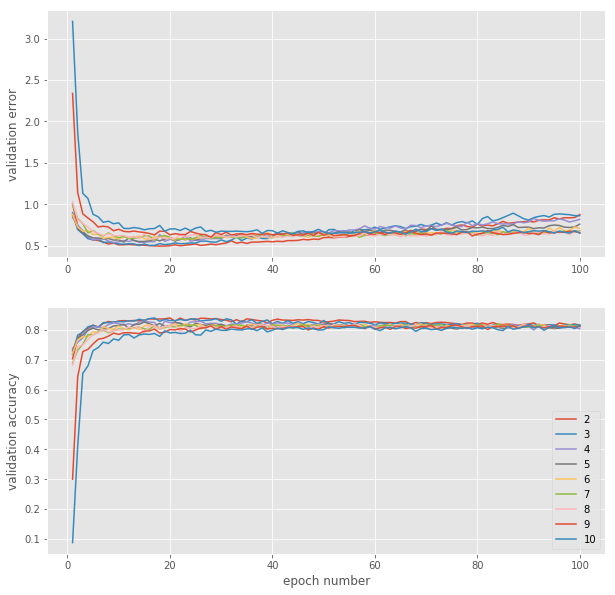

In [23]:
# Generate some statistics for RELU layer:
final_valid_err_relu = []
final_valid_acc_relu = []

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (layer, output) in experiment_layers_relu.items():
    keys = output[1]
    stats = output[0]
    # Store the statistics for this model
    final_valid_err_relu.append(stats[-1, keys['error(valid)']])
    final_valid_acc_relu.append(stats[-1, keys['acc(valid)']])
    # plot the accuracy for each layer
    ax1.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['error(valid)']])
    ax2.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['acc(valid)']], 
        label=layer)
    
ax2.legend(loc='best');
ax1.set_ylabel('validation error')
ax2.set_ylabel('validation accuracy')
ax2.set_xlabel('epoch number')

#### Sigmoid Layer

In [16]:
func = SigmoidLayer()
experiment_layers_sigmoid = {}

In [17]:
for i in range(1, 10):
    train_data.reset()
    test_data.reset()
    valid_data.reset()

    # Initialise the weights and biases:
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
    ]
    output_layer = [
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]
    each_hidden_layer = [
        func,
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)
    ]

    # create the MLP:
    model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                               output_layer)
    print(model, '{} layers'.format(i + 1))

    error = CrossEntropySoftmaxError()
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers_sigmoid[i + 1] = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        num_epochs,
        stats_interval,
        notebook=False)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SigmoidLayer
    AffineLayer(input_dim=100, output_dim=100)
    SigmoidLayer
    AffineLayer(input_dim=100, output_dim=47)
) 2 layers


Epoch 1: 2.4s to complete
    error(train)=3.05e+00, acc(train)=2.67e-01, error(valid)=3.05e+00, acc(valid)=2.64e-01, error(test)=3.06e+00, acc(test)=2.57e-01
Epoch 2: 2.4s to complete
    error(train)=2.08e+00, acc(train)=4.73e-01, error(valid)=2.08e+00, acc(valid)=4.73e-01, error(test)=2.10e+00, acc(test)=4.65e-01
Epoch 3: 2.4s to complete
    error(train)=1.64e+00, acc(train)=5.66e-01, error(valid)=1.65e+00, acc(valid)=5.58e-01, error(test)=1.66e+00, acc(test)=5.55e-01
Epoch 4: 2.4s to complete
    error(train)=1.42e+00, acc(train)=6.09e-01, error(valid)=1.43e+00, acc(valid)=6.02e-01, error(test)=1.44e+00, acc(test)=5.98e-01
Epoch 5: 2.4s to complete
    error(train)=1.29e+00, acc(train)=6.39e-01, error(valid)=1.30e+00, acc(valid)=6.32e-01, error(test)=1.31e+00, acc(test)=6.25e-01
Epoch 6: 2.4s to complete
    error(train)=1.20e+00, acc(train)=6.61e-01, error(valid)=1.21e+00, acc(valid)=6.54e-01, error(test)=1.22e+00, acc(test)=6.47e-01
Epoch 7: 2.4s to complete
    error(train)=1.1

Epoch 53: 2.4s to complete
    error(train)=4.50e-01, acc(train)=8.53e-01, error(valid)=5.26e-01, acc(valid)=8.28e-01, error(test)=5.60e-01, acc(test)=8.18e-01
Epoch 54: 2.4s to complete
    error(train)=4.47e-01, acc(train)=8.53e-01, error(valid)=5.25e-01, acc(valid)=8.29e-01, error(test)=5.62e-01, acc(test)=8.19e-01
Epoch 55: 2.4s to complete
    error(train)=4.45e-01, acc(train)=8.54e-01, error(valid)=5.25e-01, acc(valid)=8.29e-01, error(test)=5.60e-01, acc(test)=8.20e-01
Epoch 56: 2.4s to complete
    error(train)=4.41e-01, acc(train)=8.56e-01, error(valid)=5.22e-01, acc(valid)=8.29e-01, error(test)=5.56e-01, acc(test)=8.20e-01
Epoch 57: 2.4s to complete
    error(train)=4.38e-01, acc(train)=8.55e-01, error(valid)=5.21e-01, acc(valid)=8.30e-01, error(test)=5.57e-01, acc(test)=8.19e-01
Epoch 58: 2.4s to complete
    error(train)=4.36e-01, acc(train)=8.57e-01, error(valid)=5.20e-01, acc(valid)=8.30e-01, error(test)=5.54e-01, acc(test)=8.21e-01
Epoch 59: 2.4s to complete
    error(tra

limit_output extension: Maximum message size of 10000 exceeded with 10113 characters

Text(0.5,0,'epoch number')

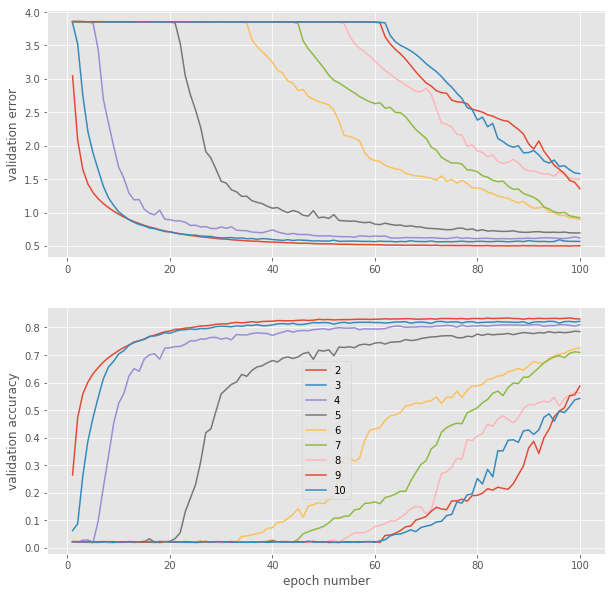

In [25]:
# Generate some statistics for SIGMOID layer:
final_valid_err_sigmoid = []
final_valid_acc_sigmoid = []

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (layer, output) in experiment_layers_sigmoid.items():
    keys = output[1]
    stats = output[0]
    # Store the statistics for this model
    final_valid_err_sigmoid.append(stats[-1, keys['error(valid)']])
    final_valid_acc_sigmoid.append(stats[-1, keys['acc(valid)']])
    # plot the accuracy for each layer
    ax1.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['error(valid)']])
    ax2.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['acc(valid)']], 
        label=layer)
    
ax2.legend(loc='best');
ax1.set_ylabel('validation error')
ax2.set_ylabel('validation accuracy')
ax2.set_xlabel('epoch number')

#### ELU Layer

In [26]:
func = ELULayer()
experiment_layers_elu = {}

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 2 layers


Epoch 1: 3.0s to complete
    error(train)=9.88e-01, acc(train)=7.11e-01, error(valid)=9.98e-01, acc(valid)=7.07e-01, error(test)=1.03e+00, acc(test)=6.96e-01
Epoch 2: 3.0s to complete
    error(train)=7.74e-01, acc(train)=7.63e-01, error(valid)=7.97e-01, acc(valid)=7.56e-01, error(test)=8.30e-01, acc(test)=7.43e-01
Epoch 3: 3.0s to complete
    error(train)=6.69e-01, acc(train)=7.90e-01, error(valid)=7.00e-01, acc(valid)=7.80e-01, error(test)=7.35e-01, acc(test)=7.70e-01
Epoch 4: 3.0s to complete
    error(train)=5.95e-01, acc(train)=8.09e-01, error(valid)=6.35e-01, acc(valid)=8.01e-01, error(test)=6.66e-01, acc(test)=7.91e-01
Epoch 5: 3.0s to complete
    error(train)=5.45e-01, acc(train)=8.25e-01, error(valid)=5.92e-01, acc(valid)=8.13e-01, error(test)=6.27e-01, acc(test)=8.05e-01
Epoch 6: 3.0s to complete
    error(train)=5.10e-01, acc(train)=8.34e-01, error(valid)=5.60e-01, acc(valid)=8.20e-01, error(test)=6.00e-01, acc(test)=8.08e-01
Epoch 7: 3.0s to complete
    error(train)=4.9

Epoch 53: 3.0s to complete
    error(train)=2.36e-01, acc(train)=9.10e-01, error(valid)=5.88e-01, acc(valid)=8.36e-01, error(test)=6.32e-01, acc(test)=8.24e-01
Epoch 54: 3.0s to complete
    error(train)=2.26e-01, acc(train)=9.14e-01, error(valid)=5.86e-01, acc(valid)=8.38e-01, error(test)=6.32e-01, acc(test)=8.25e-01
Epoch 55: 3.0s to complete
    error(train)=2.19e-01, acc(train)=9.18e-01, error(valid)=5.83e-01, acc(valid)=8.37e-01, error(test)=6.37e-01, acc(test)=8.22e-01
Epoch 56: 3.0s to complete
    error(train)=2.17e-01, acc(train)=9.18e-01, error(valid)=5.98e-01, acc(valid)=8.38e-01, error(test)=6.40e-01, acc(test)=8.28e-01
Epoch 57: 3.0s to complete
    error(train)=2.15e-01, acc(train)=9.17e-01, error(valid)=5.99e-01, acc(valid)=8.35e-01, error(test)=6.42e-01, acc(test)=8.23e-01
Epoch 58: 3.0s to complete
    error(train)=2.21e-01, acc(train)=9.14e-01, error(valid)=6.06e-01, acc(valid)=8.31e-01, error(test)=6.52e-01, acc(test)=8.20e-01
Epoch 59: 3.0s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 3 layers


Epoch 1: 3.7s to complete
    error(train)=8.65e-01, acc(train)=7.36e-01, error(valid)=8.80e-01, acc(valid)=7.32e-01, error(test)=8.96e-01, acc(test)=7.26e-01
Epoch 2: 3.7s to complete
    error(train)=6.57e-01, acc(train)=7.92e-01, error(valid)=6.84e-01, acc(valid)=7.85e-01, error(test)=7.18e-01, acc(test)=7.72e-01
Epoch 3: 3.7s to complete
    error(train)=5.91e-01, acc(train)=8.09e-01, error(valid)=6.30e-01, acc(valid)=8.01e-01, error(test)=6.65e-01, acc(test)=7.88e-01
Epoch 4: 3.7s to complete
    error(train)=5.39e-01, acc(train)=8.20e-01, error(valid)=5.92e-01, acc(valid)=8.07e-01, error(test)=6.29e-01, acc(test)=7.98e-01
Epoch 5: 3.7s to complete
    error(train)=4.89e-01, acc(train)=8.38e-01, error(valid)=5.54e-01, acc(valid)=8.23e-01, error(test)=5.83e-01, acc(test)=8.12e-01
Epoch 6: 3.7s to complete
    error(train)=4.62e-01, acc(train)=8.42e-01, error(valid)=5.36e-01, acc(valid)=8.25e-01, error(test)=5.66e-01, acc(test)=8.17e-01
Epoch 7: 3.7s to complete
    error(train)=4.4

Epoch 53: 3.7s to complete
    error(train)=2.31e-01, acc(train)=9.08e-01, error(valid)=7.15e-01, acc(valid)=8.20e-01, error(test)=7.71e-01, acc(test)=8.16e-01
Epoch 54: 3.8s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=7.30e-01, acc(valid)=8.16e-01, error(test)=7.76e-01, acc(test)=8.14e-01
Epoch 55: 3.7s to complete
    error(train)=2.36e-01, acc(train)=9.07e-01, error(valid)=7.23e-01, acc(valid)=8.22e-01, error(test)=7.84e-01, acc(test)=8.12e-01
Epoch 56: 3.7s to complete
    error(train)=2.13e-01, acc(train)=9.16e-01, error(valid)=7.21e-01, acc(valid)=8.23e-01, error(test)=7.76e-01, acc(test)=8.15e-01
Epoch 57: 3.8s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=7.17e-01, acc(valid)=8.26e-01, error(test)=7.79e-01, acc(test)=8.17e-01
Epoch 58: 3.7s to complete
    error(train)=2.22e-01, acc(train)=9.10e-01, error(valid)=7.34e-01, acc(valid)=8.22e-01, error(test)=7.97e-01, acc(test)=8.15e-01
Epoch 59: 3.7s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 4 layers


Epoch 1: 4.4s to complete
    error(train)=8.13e-01, acc(train)=7.48e-01, error(valid)=8.31e-01, acc(valid)=7.42e-01, error(test)=8.58e-01, acc(test)=7.33e-01
Epoch 2: 4.4s to complete
    error(train)=6.47e-01, acc(train)=7.91e-01, error(valid)=6.80e-01, acc(valid)=7.83e-01, error(test)=7.09e-01, acc(test)=7.69e-01
Epoch 3: 4.4s to complete
    error(train)=5.55e-01, acc(train)=8.17e-01, error(valid)=6.01e-01, acc(valid)=8.04e-01, error(test)=6.39e-01, acc(test)=7.90e-01
Epoch 4: 4.4s to complete
    error(train)=5.11e-01, acc(train)=8.27e-01, error(valid)=5.67e-01, acc(valid)=8.11e-01, error(test)=5.99e-01, acc(test)=8.01e-01
Epoch 5: 4.4s to complete
    error(train)=4.71e-01, acc(train)=8.40e-01, error(valid)=5.37e-01, acc(valid)=8.25e-01, error(test)=5.75e-01, acc(test)=8.11e-01
Epoch 6: 4.4s to complete
    error(train)=4.54e-01, acc(train)=8.43e-01, error(valid)=5.33e-01, acc(valid)=8.21e-01, error(test)=5.73e-01, acc(test)=8.09e-01
Epoch 7: 4.4s to complete
    error(train)=4.3

Epoch 53: 4.3s to complete
    error(train)=2.47e-01, acc(train)=9.01e-01, error(valid)=6.87e-01, acc(valid)=8.17e-01, error(test)=7.69e-01, acc(test)=8.06e-01
Epoch 54: 4.3s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=6.87e-01, acc(valid)=8.25e-01, error(test)=7.57e-01, acc(test)=8.09e-01
Epoch 55: 4.7s to complete
    error(train)=2.52e-01, acc(train)=9.00e-01, error(valid)=6.98e-01, acc(valid)=8.16e-01, error(test)=7.74e-01, acc(test)=8.06e-01
Epoch 56: 4.7s to complete
    error(train)=2.36e-01, acc(train)=9.07e-01, error(valid)=6.87e-01, acc(valid)=8.23e-01, error(test)=7.65e-01, acc(test)=8.13e-01
Epoch 57: 4.6s to complete
    error(train)=2.49e-01, acc(train)=9.02e-01, error(valid)=7.03e-01, acc(valid)=8.17e-01, error(test)=7.78e-01, acc(test)=8.05e-01
Epoch 58: 4.3s to complete
    error(train)=2.37e-01, acc(train)=9.06e-01, error(valid)=7.03e-01, acc(valid)=8.20e-01, error(test)=7.90e-01, acc(test)=8.09e-01
Epoch 59: 4.3s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 5 layers


Epoch 1: 5.1s to complete
    error(train)=7.75e-01, acc(train)=7.56e-01, error(valid)=8.05e-01, acc(valid)=7.49e-01, error(test)=8.31e-01, acc(test)=7.36e-01
Epoch 2: 5.1s to complete
    error(train)=6.33e-01, acc(train)=7.97e-01, error(valid)=6.77e-01, acc(valid)=7.84e-01, error(test)=7.08e-01, acc(test)=7.75e-01
Epoch 3: 5.1s to complete
    error(train)=5.54e-01, acc(train)=8.10e-01, error(valid)=6.18e-01, acc(valid)=7.92e-01, error(test)=6.46e-01, acc(test)=7.88e-01
Epoch 4: 5.1s to complete
    error(train)=5.15e-01, acc(train)=8.26e-01, error(valid)=5.87e-01, acc(valid)=8.09e-01, error(test)=6.24e-01, acc(test)=7.97e-01
Epoch 5: 5.0s to complete
    error(train)=5.04e-01, acc(train)=8.25e-01, error(valid)=5.92e-01, acc(valid)=8.03e-01, error(test)=6.18e-01, acc(test)=7.98e-01
Epoch 6: 5.6s to complete
    error(train)=4.68e-01, acc(train)=8.39e-01, error(valid)=5.62e-01, acc(valid)=8.16e-01, error(test)=5.96e-01, acc(test)=8.07e-01
Epoch 7: 5.1s to complete
    error(train)=4.4

Epoch 53: 4.9s to complete
    error(train)=2.84e-01, acc(train)=8.86e-01, error(valid)=6.94e-01, acc(valid)=8.10e-01, error(test)=7.48e-01, acc(test)=8.00e-01
Epoch 54: 5.2s to complete
    error(train)=2.68e-01, acc(train)=8.95e-01, error(valid)=6.69e-01, acc(valid)=8.16e-01, error(test)=7.06e-01, acc(test)=8.08e-01
Epoch 55: 4.9s to complete
    error(train)=2.77e-01, acc(train)=8.92e-01, error(valid)=6.80e-01, acc(valid)=8.11e-01, error(test)=7.38e-01, acc(test)=8.05e-01
Epoch 56: 5.0s to complete
    error(train)=2.77e-01, acc(train)=8.91e-01, error(valid)=6.94e-01, acc(valid)=8.09e-01, error(test)=7.41e-01, acc(test)=8.02e-01
Epoch 57: 5.0s to complete
    error(train)=2.82e-01, acc(train)=8.89e-01, error(valid)=6.99e-01, acc(valid)=8.10e-01, error(test)=7.51e-01, acc(test)=7.99e-01
Epoch 58: 5.0s to complete
    error(train)=2.69e-01, acc(train)=8.95e-01, error(valid)=6.98e-01, acc(valid)=8.16e-01, error(test)=7.52e-01, acc(test)=8.08e-01
Epoch 59: 5.0s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 6 layers


Epoch 1: 5.8s to complete
    error(train)=7.74e-01, acc(train)=7.57e-01, error(valid)=8.03e-01, acc(valid)=7.48e-01, error(test)=8.32e-01, acc(test)=7.40e-01
Epoch 2: 5.7s to complete
    error(train)=6.23e-01, acc(train)=7.92e-01, error(valid)=6.65e-01, acc(valid)=7.79e-01, error(test)=7.00e-01, acc(test)=7.72e-01
Epoch 3: 5.7s to complete
    error(train)=5.55e-01, acc(train)=8.14e-01, error(valid)=6.16e-01, acc(valid)=7.98e-01, error(test)=6.35e-01, acc(test)=7.92e-01
Epoch 4: 5.7s to complete
    error(train)=5.29e-01, acc(train)=8.20e-01, error(valid)=6.05e-01, acc(valid)=8.03e-01, error(test)=6.26e-01, acc(test)=7.95e-01
Epoch 5: 5.7s to complete
    error(train)=5.16e-01, acc(train)=8.17e-01, error(valid)=6.02e-01, acc(valid)=7.94e-01, error(test)=6.27e-01, acc(test)=7.89e-01
Epoch 6: 5.7s to complete
    error(train)=4.88e-01, acc(train)=8.28e-01, error(valid)=5.90e-01, acc(valid)=8.04e-01, error(test)=6.16e-01, acc(test)=7.95e-01
Epoch 7: 5.7s to complete
    error(train)=4.5

Epoch 53: 5.6s to complete
    error(train)=2.98e-01, acc(train)=8.84e-01, error(valid)=6.44e-01, acc(valid)=8.16e-01, error(test)=6.89e-01, acc(test)=8.06e-01
Epoch 54: 5.6s to complete
    error(train)=2.98e-01, acc(train)=8.85e-01, error(valid)=6.54e-01, acc(valid)=8.14e-01, error(test)=6.86e-01, acc(test)=8.07e-01
Epoch 55: 5.6s to complete
    error(train)=2.98e-01, acc(train)=8.87e-01, error(valid)=6.50e-01, acc(valid)=8.13e-01, error(test)=6.82e-01, acc(test)=8.08e-01
Epoch 56: 5.5s to complete
    error(train)=2.96e-01, acc(train)=8.83e-01, error(valid)=6.55e-01, acc(valid)=8.08e-01, error(test)=6.93e-01, acc(test)=8.05e-01
Epoch 57: 5.6s to complete
    error(train)=2.92e-01, acc(train)=8.84e-01, error(valid)=6.53e-01, acc(valid)=8.09e-01, error(test)=6.84e-01, acc(test)=8.05e-01
Epoch 58: 5.6s to complete
    error(train)=3.03e-01, acc(train)=8.84e-01, error(valid)=6.71e-01, acc(valid)=8.11e-01, error(test)=7.09e-01, acc(test)=8.05e-01
Epoch 59: 5.5s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 7 layers


Epoch 1: 6.4s to complete
    error(train)=8.03e-01, acc(train)=7.41e-01, error(valid)=8.30e-01, acc(valid)=7.37e-01, error(test)=8.51e-01, acc(test)=7.27e-01
Epoch 2: 6.4s to complete
    error(train)=6.73e-01, acc(train)=7.81e-01, error(valid)=7.20e-01, acc(valid)=7.72e-01, error(test)=7.41e-01, acc(test)=7.61e-01
Epoch 3: 6.6s to complete
    error(train)=5.75e-01, acc(train)=8.06e-01, error(valid)=6.34e-01, acc(valid)=7.92e-01, error(test)=6.61e-01, acc(test)=7.81e-01
Epoch 4: 6.4s to complete
    error(train)=5.40e-01, acc(train)=8.18e-01, error(valid)=6.07e-01, acc(valid)=8.00e-01, error(test)=6.40e-01, acc(test)=7.93e-01
Epoch 5: 6.3s to complete
    error(train)=5.16e-01, acc(train)=8.23e-01, error(valid)=6.00e-01, acc(valid)=8.04e-01, error(test)=6.28e-01, acc(test)=7.94e-01
Epoch 6: 6.3s to complete
    error(train)=5.22e-01, acc(train)=8.16e-01, error(valid)=6.10e-01, acc(valid)=7.97e-01, error(test)=6.37e-01, acc(test)=7.87e-01
Epoch 7: 6.3s to complete
    error(train)=4.7

Epoch 53: 6.2s to complete
    error(train)=3.15e-01, acc(train)=8.79e-01, error(valid)=6.21e-01, acc(valid)=8.12e-01, error(test)=6.54e-01, acc(test)=8.04e-01
Epoch 54: 6.2s to complete
    error(train)=3.35e-01, acc(train)=8.74e-01, error(valid)=6.49e-01, acc(valid)=8.10e-01, error(test)=6.82e-01, acc(test)=8.01e-01
Epoch 55: 6.2s to complete
    error(train)=3.18e-01, acc(train)=8.80e-01, error(valid)=6.33e-01, acc(valid)=8.12e-01, error(test)=6.52e-01, acc(test)=8.04e-01
Epoch 56: 6.2s to complete
    error(train)=3.15e-01, acc(train)=8.81e-01, error(valid)=6.33e-01, acc(valid)=8.10e-01, error(test)=6.56e-01, acc(test)=8.05e-01
Epoch 57: 6.2s to complete
    error(train)=3.17e-01, acc(train)=8.80e-01, error(valid)=6.34e-01, acc(valid)=8.09e-01, error(test)=6.67e-01, acc(test)=8.02e-01
Epoch 58: 6.2s to complete
    error(train)=3.28e-01, acc(train)=8.75e-01, error(valid)=6.48e-01, acc(valid)=8.08e-01, error(test)=6.77e-01, acc(test)=7.99e-01
Epoch 59: 6.2s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 8 layers


Epoch 1: 7.0s to complete
    error(train)=7.78e-01, acc(train)=7.52e-01, error(valid)=8.04e-01, acc(valid)=7.44e-01, error(test)=8.37e-01, acc(test)=7.33e-01
Epoch 2: 7.0s to complete
    error(train)=6.50e-01, acc(train)=7.85e-01, error(valid)=6.95e-01, acc(valid)=7.75e-01, error(test)=7.21e-01, acc(test)=7.65e-01
Epoch 3: 7.0s to complete
    error(train)=6.14e-01, acc(train)=7.93e-01, error(valid)=6.71e-01, acc(valid)=7.81e-01, error(test)=6.99e-01, acc(test)=7.71e-01
Epoch 4: 7.0s to complete
    error(train)=5.34e-01, acc(train)=8.19e-01, error(valid)=6.03e-01, acc(valid)=8.05e-01, error(test)=6.33e-01, acc(test)=7.93e-01
Epoch 5: 6.9s to complete
    error(train)=5.16e-01, acc(train)=8.24e-01, error(valid)=6.04e-01, acc(valid)=8.01e-01, error(test)=6.23e-01, acc(test)=7.92e-01
Epoch 6: 6.9s to complete
    error(train)=5.02e-01, acc(train)=8.27e-01, error(valid)=5.92e-01, acc(valid)=8.04e-01, error(test)=6.25e-01, acc(test)=7.95e-01
Epoch 7: 6.9s to complete
    error(train)=5.2

Epoch 53: 7.2s to complete
    error(train)=3.21e-01, acc(train)=8.79e-01, error(valid)=6.05e-01, acc(valid)=8.19e-01, error(test)=6.36e-01, acc(test)=8.09e-01
Epoch 54: 7.0s to complete
    error(train)=3.21e-01, acc(train)=8.80e-01, error(valid)=6.00e-01, acc(valid)=8.23e-01, error(test)=6.30e-01, acc(test)=8.10e-01
Epoch 55: 7.0s to complete
    error(train)=3.20e-01, acc(train)=8.81e-01, error(valid)=5.98e-01, acc(valid)=8.19e-01, error(test)=6.31e-01, acc(test)=8.11e-01
Epoch 56: 7.1s to complete
    error(train)=3.42e-01, acc(train)=8.71e-01, error(valid)=6.17e-01, acc(valid)=8.15e-01, error(test)=6.43e-01, acc(test)=8.07e-01
Epoch 57: 7.2s to complete
    error(train)=3.25e-01, acc(train)=8.78e-01, error(valid)=6.25e-01, acc(valid)=8.16e-01, error(test)=6.45e-01, acc(test)=8.08e-01
Epoch 58: 7.3s to complete
    error(train)=3.30e-01, acc(train)=8.75e-01, error(valid)=6.24e-01, acc(valid)=8.16e-01, error(test)=6.38e-01, acc(test)=8.07e-01
Epoch 59: 7.5s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 9 layers


Epoch 1: 7.7s to complete
    error(train)=8.08e-01, acc(train)=7.44e-01, error(valid)=8.38e-01, acc(valid)=7.35e-01, error(test)=8.60e-01, acc(test)=7.30e-01
Epoch 2: 7.7s to complete
    error(train)=6.57e-01, acc(train)=7.84e-01, error(valid)=6.99e-01, acc(valid)=7.75e-01, error(test)=7.25e-01, acc(test)=7.64e-01
Epoch 3: 7.6s to complete
    error(train)=6.18e-01, acc(train)=7.98e-01, error(valid)=6.73e-01, acc(valid)=7.85e-01, error(test)=7.00e-01, acc(test)=7.77e-01
Epoch 4: 7.6s to complete
    error(train)=5.69e-01, acc(train)=8.04e-01, error(valid)=6.45e-01, acc(valid)=7.85e-01, error(test)=6.64e-01, acc(test)=7.78e-01
Epoch 5: 7.6s to complete
    error(train)=5.33e-01, acc(train)=8.18e-01, error(valid)=6.13e-01, acc(valid)=8.03e-01, error(test)=6.49e-01, acc(test)=7.91e-01
Epoch 6: 7.6s to complete
    error(train)=5.34e-01, acc(train)=8.19e-01, error(valid)=6.20e-01, acc(valid)=7.96e-01, error(test)=6.43e-01, acc(test)=7.90e-01
Epoch 7: 7.6s to complete
    error(train)=5.1

Epoch 53: 7.4s to complete
    error(train)=3.50e-01, acc(train)=8.71e-01, error(valid)=6.06e-01, acc(valid)=8.15e-01, error(test)=6.44e-01, acc(test)=8.04e-01
Epoch 54: 7.4s to complete
    error(train)=3.44e-01, acc(train)=8.72e-01, error(valid)=6.00e-01, acc(valid)=8.13e-01, error(test)=6.38e-01, acc(test)=8.06e-01
Epoch 55: 7.4s to complete
    error(train)=3.43e-01, acc(train)=8.72e-01, error(valid)=6.06e-01, acc(valid)=8.18e-01, error(test)=6.36e-01, acc(test)=8.07e-01
Epoch 56: 7.4s to complete
    error(train)=3.55e-01, acc(train)=8.68e-01, error(valid)=6.26e-01, acc(valid)=8.11e-01, error(test)=6.68e-01, acc(test)=8.01e-01
Epoch 57: 7.4s to complete
    error(train)=3.46e-01, acc(train)=8.72e-01, error(valid)=6.07e-01, acc(valid)=8.17e-01, error(test)=6.48e-01, acc(test)=8.06e-01
Epoch 58: 7.4s to complete
    error(train)=3.39e-01, acc(train)=8.75e-01, error(valid)=6.11e-01, acc(valid)=8.17e-01, error(test)=6.39e-01, acc(test)=8.09e-01
Epoch 59: 7.4s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=100)
    ELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 10 layers


Epoch 1: 8.4s to complete
    error(train)=8.50e-01, acc(train)=7.29e-01, error(valid)=8.89e-01, acc(valid)=7.19e-01, error(test)=9.00e-01, acc(test)=7.12e-01
Epoch 2: 8.4s to complete
    error(train)=6.95e-01, acc(train)=7.76e-01, error(valid)=7.35e-01, acc(valid)=7.67e-01, error(test)=7.68e-01, acc(test)=7.55e-01
Epoch 3: 8.3s to complete
    error(train)=6.28e-01, acc(train)=7.91e-01, error(valid)=6.88e-01, acc(valid)=7.74e-01, error(test)=7.17e-01, acc(test)=7.67e-01
Epoch 4: 8.3s to complete
    error(train)=5.82e-01, acc(train)=8.07e-01, error(valid)=6.52e-01, acc(valid)=7.89e-01, error(test)=6.76e-01, acc(test)=7.82e-01
Epoch 5: 8.3s to complete
    error(train)=5.88e-01, acc(train)=8.00e-01, error(valid)=6.58e-01, acc(valid)=7.82e-01, error(test)=6.85e-01, acc(test)=7.72e-01
Epoch 6: 8.7s to complete
    error(train)=5.33e-01, acc(train)=8.16e-01, error(valid)=6.17e-01, acc(valid)=7.96e-01, error(test)=6.43e-01, acc(test)=7.86e-01
Epoch 7: 8.7s to complete
    error(train)=5.5

Epoch 53: 8.0s to complete
    error(train)=3.99e-01, acc(train)=8.52e-01, error(valid)=6.46e-01, acc(valid)=8.01e-01, error(test)=6.64e-01, acc(test)=7.93e-01
Epoch 54: 8.0s to complete
    error(train)=3.45e-01, acc(train)=8.72e-01, error(valid)=5.99e-01, acc(valid)=8.18e-01, error(test)=6.28e-01, acc(test)=8.09e-01
Epoch 55: 8.0s to complete
    error(train)=3.66e-01, acc(train)=8.68e-01, error(valid)=6.13e-01, acc(valid)=8.16e-01, error(test)=6.46e-01, acc(test)=8.08e-01
Epoch 56: 8.1s to complete
    error(train)=3.75e-01, acc(train)=8.60e-01, error(valid)=6.12e-01, acc(valid)=8.08e-01, error(test)=6.40e-01, acc(test)=8.02e-01
Epoch 57: 8.7s to complete
    error(train)=3.49e-01, acc(train)=8.71e-01, error(valid)=5.98e-01, acc(valid)=8.20e-01, error(test)=6.31e-01, acc(test)=8.06e-01
Epoch 58: 8.1s to complete
    error(train)=3.61e-01, acc(train)=8.67e-01, error(valid)=6.09e-01, acc(valid)=8.11e-01, error(test)=6.32e-01, acc(test)=8.02e-01
Epoch 59: 8.0s to complete
    error(tra

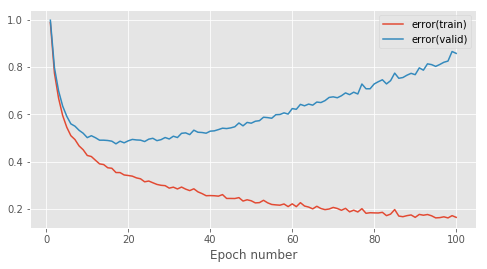

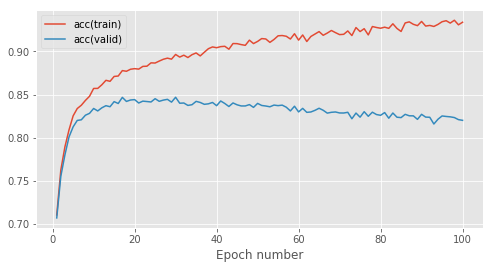

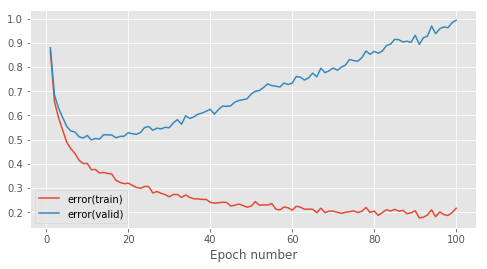

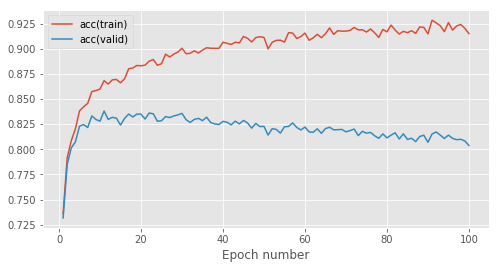

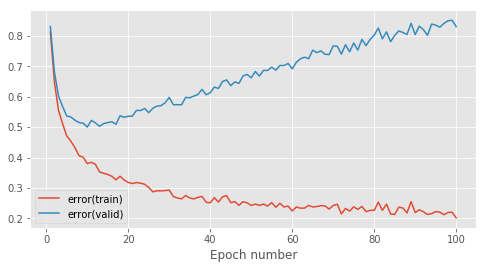

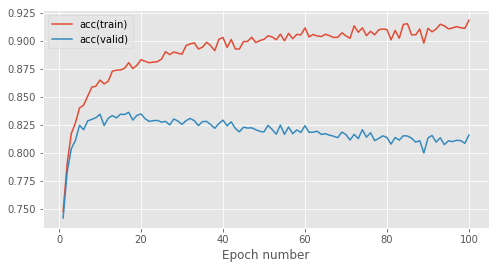

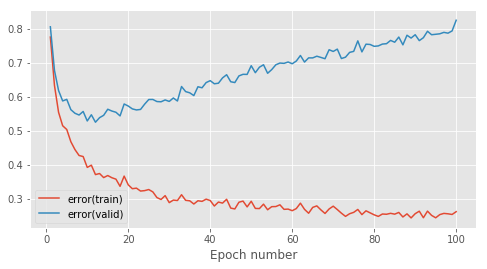

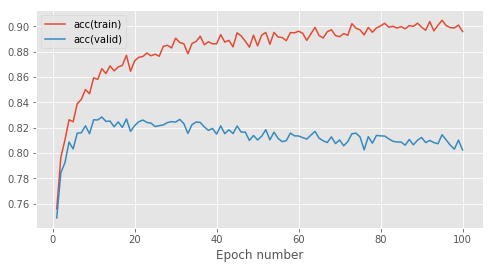

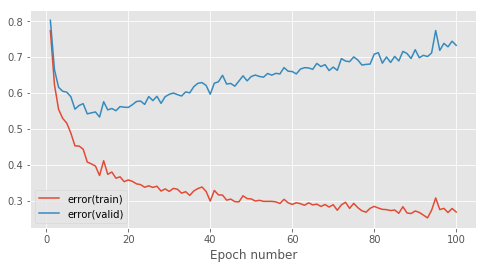

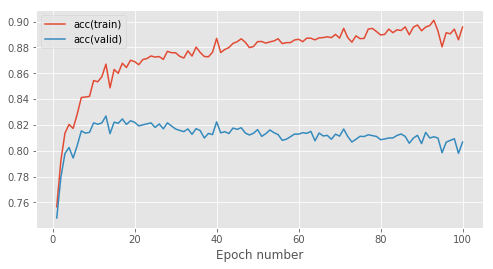

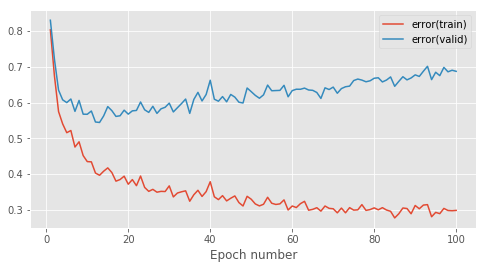

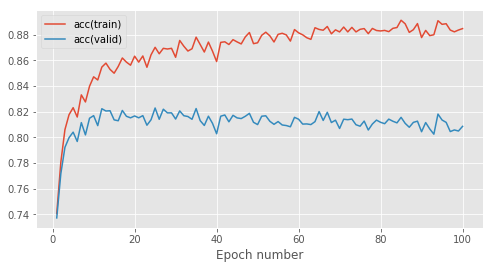

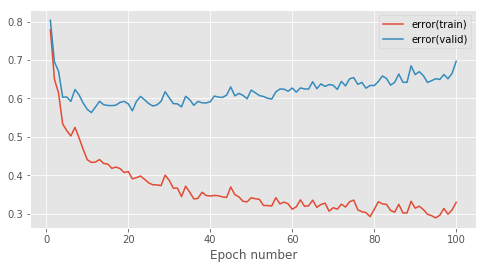

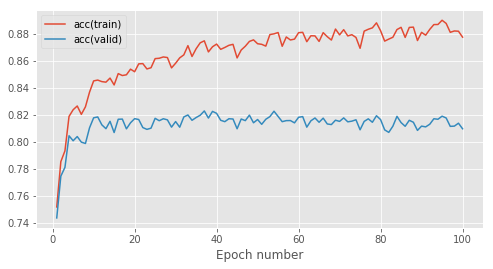

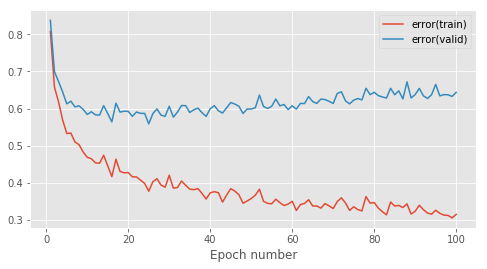

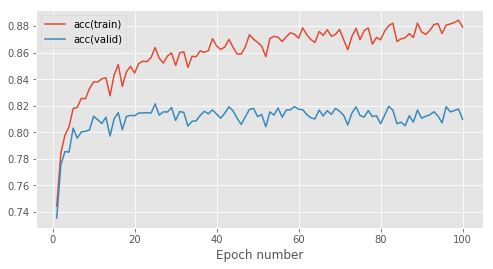

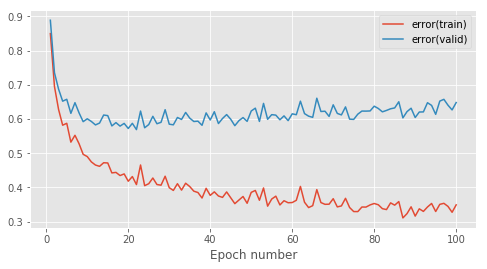

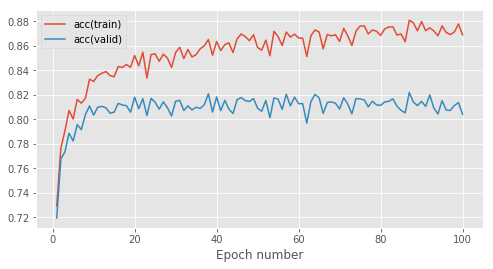

In [27]:
for i in range(1, 10):
    train_data.reset()
    test_data.reset()
    valid_data.reset()

    # Initialise the weights and biases:
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
    ]
    output_layer = [
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]
    each_hidden_layer = [
        func,
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)
    ]

    # create the MLP:
    model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                               output_layer)
    print(model, '{} layers'.format(i + 1))

    error = CrossEntropySoftmaxError()
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers_elu[i + 1] = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        num_epochs,
        stats_interval,
        notebook=False)

Text(0.5,0,'epoch number')

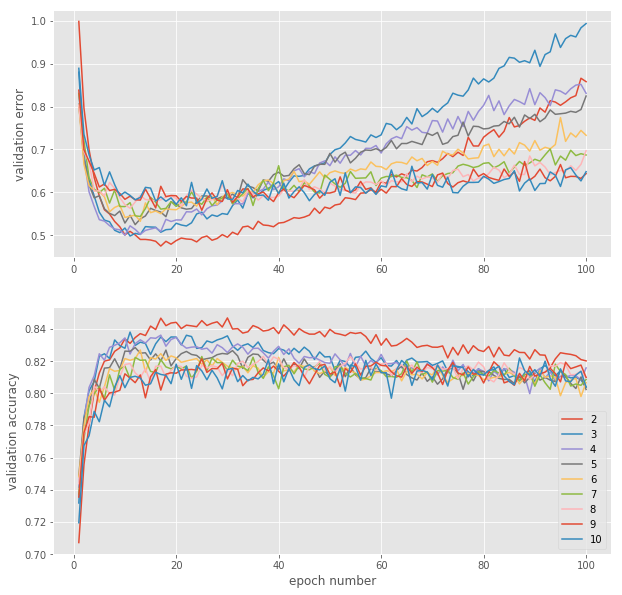

In [32]:
# Generate some statistics for SIGMOID layer:
final_valid_err_elu = []
final_valid_acc_elu = []

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (layer, output) in experiment_layers_elu.items():
    keys = output[1]
    stats = output[0]
    # Store the statistics for this model
    final_valid_err_sigmoid.append(stats[-1, keys['error(valid)']])
    final_valid_acc_sigmoid.append(stats[-1, keys['acc(valid)']])
    # plot the accuracy for each layer
    ax1.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['error(valid)']])
    ax2.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['acc(valid)']], 
        label=layer)
    
ax2.legend(loc='best');
ax1.set_ylabel('validation error')
ax2.set_ylabel('validation accuracy')
ax2.set_xlabel('epoch number')

#### SELU Layer

In [28]:
func = SELULayer()
experiment_layers_selu = {}

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 2 layers


Epoch 1: 3.1s to complete
    error(train)=9.68e-01, acc(train)=7.21e-01, error(valid)=9.76e-01, acc(valid)=7.20e-01, error(test)=1.01e+00, acc(test)=7.06e-01
Epoch 2: 3.4s to complete
    error(train)=7.58e-01, acc(train)=7.68e-01, error(valid)=7.78e-01, acc(valid)=7.60e-01, error(test)=8.15e-01, acc(test)=7.50e-01
Epoch 3: 3.1s to complete
    error(train)=6.55e-01, acc(train)=7.92e-01, error(valid)=6.84e-01, acc(valid)=7.83e-01, error(test)=7.32e-01, acc(test)=7.72e-01
Epoch 4: 3.2s to complete
    error(train)=5.83e-01, acc(train)=8.14e-01, error(valid)=6.26e-01, acc(valid)=7.97e-01, error(test)=6.64e-01, acc(test)=7.90e-01
Epoch 5: 3.1s to complete
    error(train)=5.41e-01, acc(train)=8.24e-01, error(valid)=5.89e-01, acc(valid)=8.09e-01, error(test)=6.32e-01, acc(test)=8.00e-01
Epoch 6: 3.2s to complete
    error(train)=5.10e-01, acc(train)=8.30e-01, error(valid)=5.66e-01, acc(valid)=8.13e-01, error(test)=6.08e-01, acc(test)=8.03e-01
Epoch 7: 3.6s to complete
    error(train)=4.8

Epoch 53: 3.7s to complete
    error(train)=2.35e-01, acc(train)=9.08e-01, error(valid)=5.98e-01, acc(valid)=8.31e-01, error(test)=6.49e-01, acc(test)=8.22e-01
Epoch 54: 3.7s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=6.20e-01, acc(valid)=8.25e-01, error(test)=6.65e-01, acc(test)=8.17e-01
Epoch 55: 3.7s to complete
    error(train)=2.33e-01, acc(train)=9.10e-01, error(valid)=6.20e-01, acc(valid)=8.30e-01, error(test)=6.75e-01, acc(test)=8.19e-01
Epoch 56: 3.7s to complete
    error(train)=2.30e-01, acc(train)=9.10e-01, error(valid)=6.16e-01, acc(valid)=8.30e-01, error(test)=6.78e-01, acc(test)=8.19e-01
Epoch 57: 3.7s to complete
    error(train)=2.35e-01, acc(train)=9.09e-01, error(valid)=6.19e-01, acc(valid)=8.29e-01, error(test)=6.86e-01, acc(test)=8.20e-01
Epoch 58: 3.7s to complete
    error(train)=2.31e-01, acc(train)=9.09e-01, error(valid)=6.23e-01, acc(valid)=8.31e-01, error(test)=6.95e-01, acc(test)=8.19e-01
Epoch 59: 3.7s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 3 layers


Epoch 1: 3.9s to complete
    error(train)=8.27e-01, acc(train)=7.44e-01, error(valid)=8.47e-01, acc(valid)=7.39e-01, error(test)=8.69e-01, acc(test)=7.29e-01
Epoch 2: 3.9s to complete
    error(train)=6.63e-01, acc(train)=7.86e-01, error(valid)=6.97e-01, acc(valid)=7.76e-01, error(test)=7.29e-01, acc(test)=7.69e-01
Epoch 3: 3.9s to complete
    error(train)=5.84e-01, acc(train)=8.08e-01, error(valid)=6.34e-01, acc(valid)=7.96e-01, error(test)=6.69e-01, acc(test)=7.83e-01
Epoch 4: 4.4s to complete
    error(train)=5.37e-01, acc(train)=8.20e-01, error(valid)=5.96e-01, acc(valid)=8.06e-01, error(test)=6.34e-01, acc(test)=7.94e-01
Epoch 5: 4.5s to complete
    error(train)=4.98e-01, acc(train)=8.33e-01, error(valid)=5.68e-01, acc(valid)=8.19e-01, error(test)=6.14e-01, acc(test)=8.07e-01
Epoch 6: 3.9s to complete
    error(train)=4.76e-01, acc(train)=8.35e-01, error(valid)=5.59e-01, acc(valid)=8.14e-01, error(test)=5.91e-01, acc(test)=8.08e-01
Epoch 7: 3.8s to complete
    error(train)=4.6

Epoch 53: 3.8s to complete
    error(train)=2.64e-01, acc(train)=8.96e-01, error(valid)=6.92e-01, acc(valid)=8.22e-01, error(test)=7.56e-01, acc(test)=8.09e-01
Epoch 54: 4.4s to complete
    error(train)=2.55e-01, acc(train)=8.98e-01, error(valid)=6.84e-01, acc(valid)=8.16e-01, error(test)=7.39e-01, acc(test)=8.07e-01
Epoch 55: 3.8s to complete
    error(train)=2.57e-01, acc(train)=8.99e-01, error(valid)=7.02e-01, acc(valid)=8.19e-01, error(test)=7.80e-01, acc(test)=8.10e-01
Epoch 56: 4.1s to complete
    error(train)=2.57e-01, acc(train)=9.01e-01, error(valid)=7.26e-01, acc(valid)=8.19e-01, error(test)=7.96e-01, acc(test)=8.07e-01
Epoch 57: 3.8s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=6.96e-01, acc(valid)=8.21e-01, error(test)=7.71e-01, acc(test)=8.11e-01
Epoch 58: 3.8s to complete
    error(train)=2.72e-01, acc(train)=8.92e-01, error(valid)=7.38e-01, acc(valid)=8.09e-01, error(test)=8.02e-01, acc(test)=8.00e-01
Epoch 59: 3.8s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 4 layers


Epoch 1: 4.5s to complete
    error(train)=8.23e-01, acc(train)=7.38e-01, error(valid)=8.47e-01, acc(valid)=7.29e-01, error(test)=8.71e-01, acc(test)=7.26e-01
Epoch 2: 4.6s to complete
    error(train)=6.25e-01, acc(train)=7.98e-01, error(valid)=6.69e-01, acc(valid)=7.87e-01, error(test)=7.04e-01, acc(test)=7.77e-01
Epoch 3: 4.6s to complete
    error(train)=5.71e-01, acc(train)=8.11e-01, error(valid)=6.31e-01, acc(valid)=8.01e-01, error(test)=6.64e-01, acc(test)=7.87e-01
Epoch 4: 4.5s to complete
    error(train)=5.32e-01, acc(train)=8.18e-01, error(valid)=6.01e-01, acc(valid)=8.02e-01, error(test)=6.33e-01, acc(test)=7.94e-01
Epoch 5: 4.5s to complete
    error(train)=5.08e-01, acc(train)=8.26e-01, error(valid)=5.85e-01, acc(valid)=8.10e-01, error(test)=6.25e-01, acc(test)=7.95e-01
Epoch 6: 4.6s to complete
    error(train)=4.76e-01, acc(train)=8.37e-01, error(valid)=5.62e-01, acc(valid)=8.16e-01, error(test)=6.06e-01, acc(test)=8.04e-01
Epoch 7: 4.5s to complete
    error(train)=4.6

Epoch 53: 4.5s to complete
    error(train)=3.04e-01, acc(train)=8.85e-01, error(valid)=6.88e-01, acc(valid)=8.19e-01, error(test)=7.33e-01, acc(test)=8.06e-01
Epoch 54: 4.5s to complete
    error(train)=2.93e-01, acc(train)=8.89e-01, error(valid)=6.82e-01, acc(valid)=8.19e-01, error(test)=7.13e-01, acc(test)=8.10e-01
Epoch 55: 4.5s to complete
    error(train)=3.03e-01, acc(train)=8.82e-01, error(valid)=6.88e-01, acc(valid)=8.09e-01, error(test)=7.35e-01, acc(test)=8.02e-01
Epoch 56: 4.5s to complete
    error(train)=3.01e-01, acc(train)=8.82e-01, error(valid)=6.93e-01, acc(valid)=8.10e-01, error(test)=7.20e-01, acc(test)=8.04e-01
Epoch 57: 4.5s to complete
    error(train)=2.99e-01, acc(train)=8.85e-01, error(valid)=6.91e-01, acc(valid)=8.13e-01, error(test)=7.20e-01, acc(test)=8.05e-01
Epoch 58: 4.5s to complete
    error(train)=2.96e-01, acc(train)=8.83e-01, error(valid)=6.96e-01, acc(valid)=8.14e-01, error(test)=7.32e-01, acc(test)=8.03e-01
Epoch 59: 4.5s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 5 layers


Epoch 1: 5.3s to complete
    error(train)=8.09e-01, acc(train)=7.46e-01, error(valid)=8.40e-01, acc(valid)=7.39e-01, error(test)=8.77e-01, acc(test)=7.27e-01
Epoch 2: 5.3s to complete
    error(train)=6.69e-01, acc(train)=7.84e-01, error(valid)=7.13e-01, acc(valid)=7.71e-01, error(test)=7.43e-01, acc(test)=7.64e-01
Epoch 3: 5.2s to complete
    error(train)=5.91e-01, acc(train)=8.04e-01, error(valid)=6.44e-01, acc(valid)=7.92e-01, error(test)=6.86e-01, acc(test)=7.81e-01
Epoch 4: 5.2s to complete
    error(train)=5.71e-01, acc(train)=8.04e-01, error(valid)=6.36e-01, acc(valid)=7.92e-01, error(test)=6.68e-01, acc(test)=7.84e-01
Epoch 5: 5.2s to complete
    error(train)=5.16e-01, acc(train)=8.24e-01, error(valid)=5.98e-01, acc(valid)=8.05e-01, error(test)=6.36e-01, acc(test)=7.97e-01
Epoch 6: 5.2s to complete
    error(train)=4.94e-01, acc(train)=8.30e-01, error(valid)=5.87e-01, acc(valid)=8.12e-01, error(test)=6.19e-01, acc(test)=8.01e-01
Epoch 7: 5.2s to complete
    error(train)=4.8

Epoch 53: 5.2s to complete
    error(train)=3.46e-01, acc(train)=8.71e-01, error(valid)=6.47e-01, acc(valid)=8.16e-01, error(test)=6.58e-01, acc(test)=8.10e-01
Epoch 54: 5.1s to complete
    error(train)=3.34e-01, acc(train)=8.74e-01, error(valid)=6.38e-01, acc(valid)=8.16e-01, error(test)=6.71e-01, acc(test)=8.04e-01
Epoch 55: 5.2s to complete
    error(train)=3.43e-01, acc(train)=8.70e-01, error(valid)=6.56e-01, acc(valid)=8.12e-01, error(test)=6.89e-01, acc(test)=8.05e-01
Epoch 56: 5.2s to complete
    error(train)=3.29e-01, acc(train)=8.77e-01, error(valid)=6.32e-01, acc(valid)=8.19e-01, error(test)=6.76e-01, acc(test)=8.09e-01
Epoch 57: 5.1s to complete
    error(train)=3.67e-01, acc(train)=8.65e-01, error(valid)=6.78e-01, acc(valid)=8.10e-01, error(test)=7.17e-01, acc(test)=7.98e-01
Epoch 58: 5.2s to complete
    error(train)=3.36e-01, acc(train)=8.74e-01, error(valid)=6.44e-01, acc(valid)=8.14e-01, error(test)=6.77e-01, acc(test)=8.04e-01
Epoch 59: 5.1s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 6 layers


Epoch 1: 6.0s to complete
    error(train)=8.04e-01, acc(train)=7.44e-01, error(valid)=8.34e-01, acc(valid)=7.38e-01, error(test)=8.61e-01, acc(test)=7.24e-01
Epoch 2: 6.0s to complete
    error(train)=6.58e-01, acc(train)=7.89e-01, error(valid)=7.07e-01, acc(valid)=7.74e-01, error(test)=7.24e-01, acc(test)=7.68e-01
Epoch 3: 5.9s to complete
    error(train)=6.21e-01, acc(train)=7.96e-01, error(valid)=6.79e-01, acc(valid)=7.84e-01, error(test)=7.12e-01, acc(test)=7.72e-01
Epoch 4: 5.9s to complete
    error(train)=6.02e-01, acc(train)=7.98e-01, error(valid)=6.64e-01, acc(valid)=7.83e-01, error(test)=7.06e-01, acc(test)=7.76e-01
Epoch 5: 6.0s to complete
    error(train)=5.41e-01, acc(train)=8.18e-01, error(valid)=6.30e-01, acc(valid)=7.99e-01, error(test)=6.61e-01, acc(test)=7.88e-01
Epoch 6: 5.9s to complete
    error(train)=5.39e-01, acc(train)=8.15e-01, error(valid)=6.24e-01, acc(valid)=7.95e-01, error(test)=6.66e-01, acc(test)=7.88e-01
Epoch 7: 5.9s to complete
    error(train)=5.2

Epoch 53: 5.8s to complete
    error(train)=3.91e-01, acc(train)=8.55e-01, error(valid)=6.46e-01, acc(valid)=8.00e-01, error(test)=6.73e-01, acc(test)=7.92e-01
Epoch 54: 5.8s to complete
    error(train)=4.17e-01, acc(train)=8.49e-01, error(valid)=6.68e-01, acc(valid)=7.96e-01, error(test)=6.94e-01, acc(test)=7.93e-01
Epoch 55: 5.8s to complete
    error(train)=3.78e-01, acc(train)=8.60e-01, error(valid)=6.37e-01, acc(valid)=8.13e-01, error(test)=6.72e-01, acc(test)=7.98e-01
Epoch 56: 5.8s to complete
    error(train)=3.74e-01, acc(train)=8.62e-01, error(valid)=6.30e-01, acc(valid)=8.09e-01, error(test)=6.60e-01, acc(test)=8.01e-01
Epoch 57: 5.8s to complete
    error(train)=3.91e-01, acc(train)=8.54e-01, error(valid)=6.56e-01, acc(valid)=7.99e-01, error(test)=6.85e-01, acc(test)=7.95e-01
Epoch 58: 5.9s to complete
    error(train)=3.67e-01, acc(train)=8.63e-01, error(valid)=6.30e-01, acc(valid)=8.08e-01, error(test)=6.67e-01, acc(test)=7.99e-01
Epoch 59: 6.4s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 7 layers


Epoch 1: 6.7s to complete
    error(train)=9.35e-01, acc(train)=6.99e-01, error(valid)=9.64e-01, acc(valid)=6.93e-01, error(test)=9.81e-01, acc(test)=6.89e-01
Epoch 2: 6.7s to complete
    error(train)=7.13e-01, acc(train)=7.70e-01, error(valid)=7.62e-01, acc(valid)=7.59e-01, error(test)=7.86e-01, acc(test)=7.53e-01
Epoch 3: 6.7s to complete
    error(train)=6.71e-01, acc(train)=7.78e-01, error(valid)=7.25e-01, acc(valid)=7.70e-01, error(test)=7.64e-01, acc(test)=7.54e-01
Epoch 4: 6.6s to complete
    error(train)=6.50e-01, acc(train)=7.89e-01, error(valid)=7.17e-01, acc(valid)=7.72e-01, error(test)=7.49e-01, acc(test)=7.69e-01
Epoch 5: 6.7s to complete
    error(train)=5.88e-01, acc(train)=8.04e-01, error(valid)=6.67e-01, acc(valid)=7.85e-01, error(test)=6.99e-01, acc(test)=7.74e-01
Epoch 6: 6.6s to complete
    error(train)=5.92e-01, acc(train)=8.02e-01, error(valid)=6.85e-01, acc(valid)=7.83e-01, error(test)=7.00e-01, acc(test)=7.77e-01
Epoch 7: 6.6s to complete
    error(train)=5.5

Epoch 53: 6.5s to complete
    error(train)=4.29e-01, acc(train)=8.44e-01, error(valid)=6.41e-01, acc(valid)=7.99e-01, error(test)=6.78e-01, acc(test)=7.93e-01
Epoch 54: 6.5s to complete
    error(train)=4.14e-01, acc(train)=8.48e-01, error(valid)=6.23e-01, acc(valid)=8.05e-01, error(test)=6.69e-01, acc(test)=7.93e-01
Epoch 55: 6.5s to complete
    error(train)=4.06e-01, acc(train)=8.52e-01, error(valid)=6.14e-01, acc(valid)=8.06e-01, error(test)=6.52e-01, acc(test)=8.02e-01
Epoch 56: 6.5s to complete
    error(train)=4.25e-01, acc(train)=8.41e-01, error(valid)=6.32e-01, acc(valid)=7.98e-01, error(test)=6.70e-01, acc(test)=7.91e-01
Epoch 57: 6.5s to complete
    error(train)=4.30e-01, acc(train)=8.44e-01, error(valid)=6.59e-01, acc(valid)=7.95e-01, error(test)=6.82e-01, acc(test)=7.92e-01
Epoch 58: 6.5s to complete
    error(train)=4.17e-01, acc(train)=8.45e-01, error(valid)=6.33e-01, acc(valid)=8.03e-01, error(test)=6.71e-01, acc(test)=7.93e-01
Epoch 59: 6.5s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 8 layers


Epoch 1: 7.4s to complete
    error(train)=8.58e-01, acc(train)=7.32e-01, error(valid)=8.86e-01, acc(valid)=7.24e-01, error(test)=9.16e-01, acc(test)=7.17e-01
Epoch 2: 7.4s to complete
    error(train)=7.45e-01, acc(train)=7.59e-01, error(valid)=7.85e-01, acc(valid)=7.46e-01, error(test)=8.05e-01, acc(test)=7.43e-01
Epoch 3: 7.3s to complete
    error(train)=7.05e-01, acc(train)=7.64e-01, error(valid)=7.53e-01, acc(valid)=7.51e-01, error(test)=7.87e-01, acc(test)=7.42e-01
Epoch 4: 7.3s to complete
    error(train)=6.38e-01, acc(train)=7.86e-01, error(valid)=6.95e-01, acc(valid)=7.73e-01, error(test)=7.32e-01, acc(test)=7.63e-01
Epoch 5: 7.3s to complete
    error(train)=6.21e-01, acc(train)=7.94e-01, error(valid)=6.87e-01, acc(valid)=7.79e-01, error(test)=7.18e-01, acc(test)=7.67e-01
Epoch 6: 7.4s to complete
    error(train)=6.17e-01, acc(train)=7.96e-01, error(valid)=6.96e-01, acc(valid)=7.77e-01, error(test)=7.16e-01, acc(test)=7.70e-01
Epoch 7: 7.3s to complete
    error(train)=6.5

Epoch 53: 7.1s to complete
    error(train)=4.69e-01, acc(train)=8.30e-01, error(valid)=6.49e-01, acc(valid)=7.96e-01, error(test)=6.73e-01, acc(test)=7.87e-01
Epoch 54: 7.1s to complete
    error(train)=4.40e-01, acc(train)=8.44e-01, error(valid)=6.25e-01, acc(valid)=8.04e-01, error(test)=6.53e-01, acc(test)=7.98e-01
Epoch 55: 7.1s to complete
    error(train)=4.55e-01, acc(train)=8.36e-01, error(valid)=6.31e-01, acc(valid)=7.98e-01, error(test)=6.68e-01, acc(test)=7.93e-01
Epoch 56: 7.1s to complete
    error(train)=4.57e-01, acc(train)=8.29e-01, error(valid)=6.38e-01, acc(valid)=7.89e-01, error(test)=6.70e-01, acc(test)=7.83e-01
Epoch 57: 7.1s to complete
    error(train)=4.57e-01, acc(train)=8.38e-01, error(valid)=6.35e-01, acc(valid)=8.00e-01, error(test)=6.59e-01, acc(test)=7.97e-01
Epoch 58: 7.1s to complete
    error(train)=4.46e-01, acc(train)=8.39e-01, error(valid)=6.35e-01, acc(valid)=7.99e-01, error(test)=6.56e-01, acc(test)=7.96e-01
Epoch 59: 7.1s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 9 layers


/Users/weiting/MLP2k1718/mlp/errors.py:171: RuntimeWarning: overflow encountered in exp
  probs = np.exp(outputs)
/Users/weiting/MLP2k1718/mlp/errors.py:172: RuntimeWarning: invalid value encountered in true_divide
  probs /= probs.sum(-1)[:, None]
/Users/weiting/MLP2k1718/mlp/layers.py:762: RuntimeWarning: invalid value encountered in maximum
  positive_inputs = np.maximum(inputs, 0.)
/Users/weiting/MLP2k1718/mlp/layers.py:765: RuntimeWarning: invalid value encountered in greater
  negative_inputs[negative_inputs > 0] = 0.
/Users/weiting/MLP2k1718/mlp/layers.py:777: RuntimeWarning: invalid value encountered in greater_equal
  positive_gradients = (outputs >= 0) * grads_wrt_outputs
/Users/weiting/MLP2k1718/mlp/layers.py:778: RuntimeWarning: invalid value encountered in less
  outputs_to_use = (outputs < 0) * outputs
/Users/weiting/MLP2k1718/mlp/layers.py:780: RuntimeWarning: invalid value encountered in greater_equal
  negative_gradients[outputs >= 0] = 0.
Epoch 1: 5.7s to complete
   

Epoch 51: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 52: 5.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 53: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 54: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 55: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 56: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 57: 5.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=100)
    SELULayer
    AffineLayer(input_dim=100, output_dim=47)
) 10 layers


Epoch 1: 6.2s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 2: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 3: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 4: 6.2s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 5: 6.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 6: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 7: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2

Epoch 58: 6.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 59: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 60: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 61: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 62: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 63: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 64: 6.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(

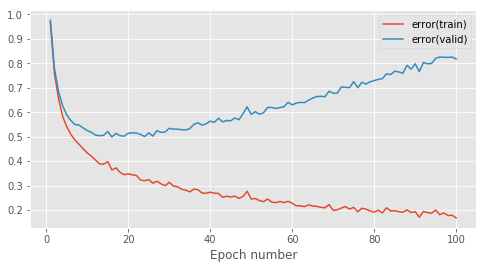

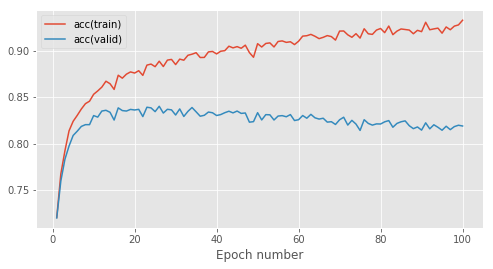

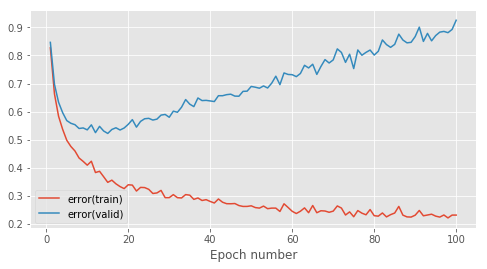

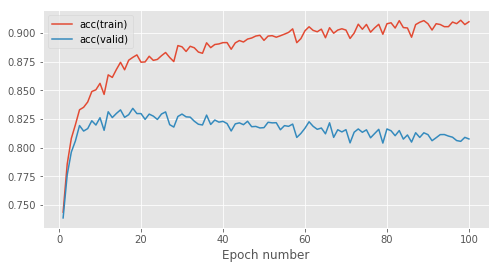

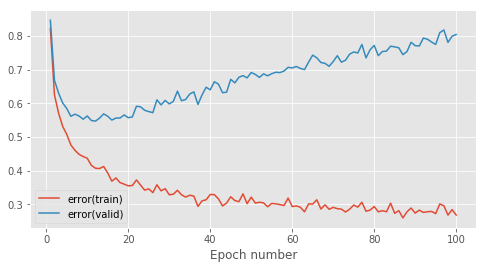

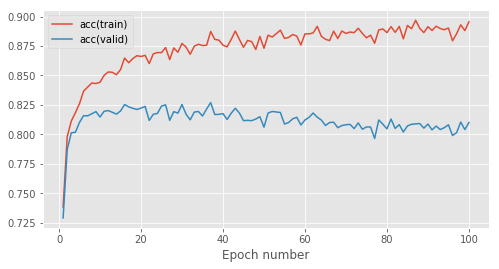

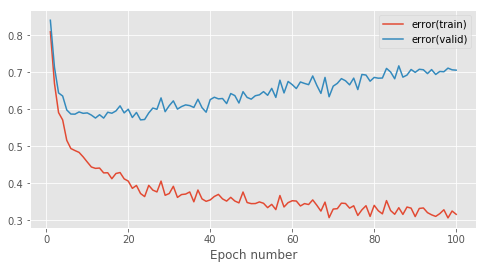

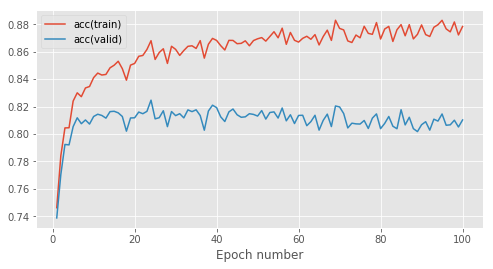

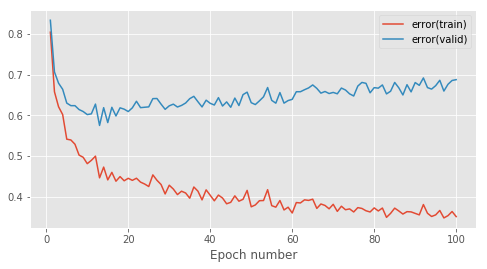

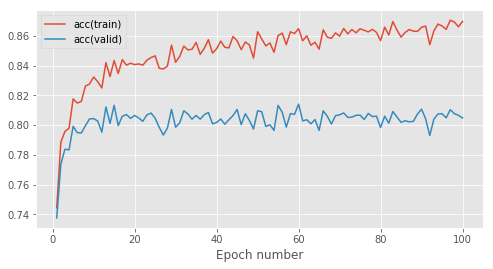

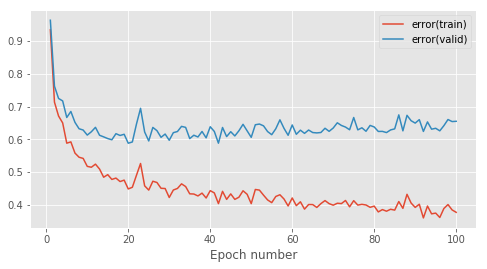

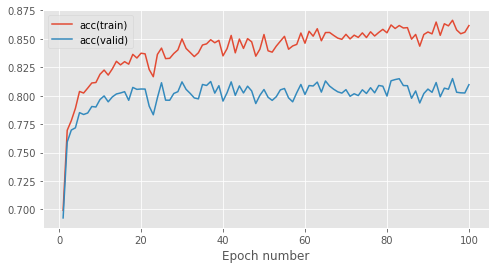

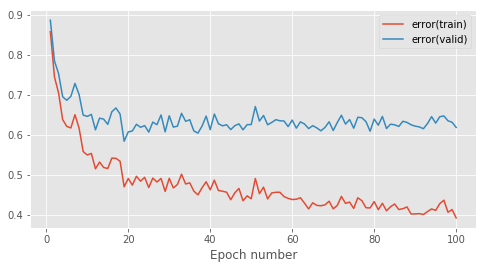

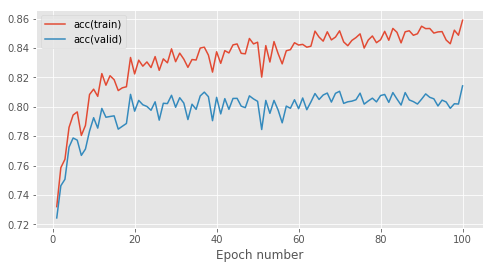

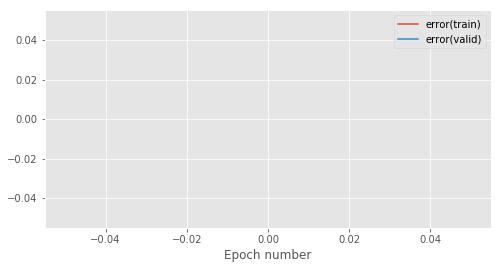

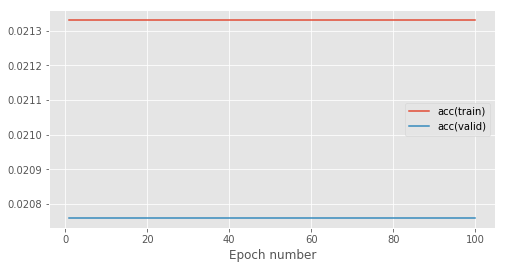

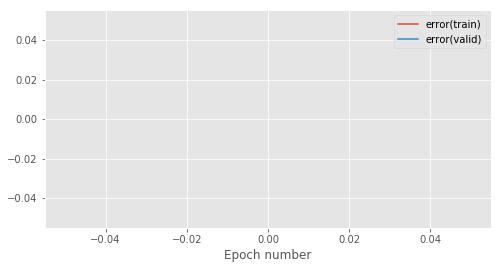

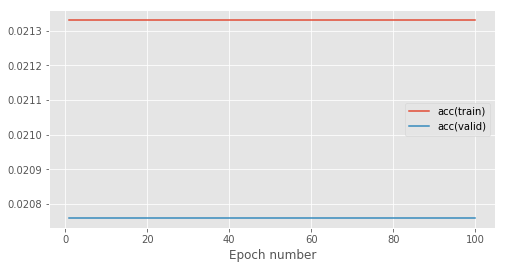

In [29]:
for i in range(1, 10):
    train_data.reset()
    test_data.reset()
    valid_data.reset()

    # Initialise the weights and biases:
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init)
    ]
    output_layer = [
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]
    each_hidden_layer = [
        func,
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init)
    ]

    # create the MLP:
    model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                               output_layer)
    print(model, '{} layers'.format(i + 1))

    error = CrossEntropySoftmaxError()
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers_selu[i + 1] = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        num_epochs,
        stats_interval,
        notebook=False)

Text(0.5,0,'epoch number')

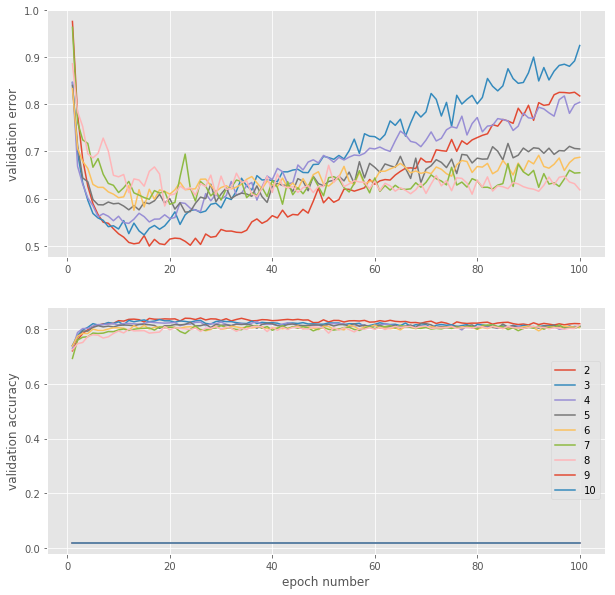

In [31]:
# Generate some statistics for SIGMOID layer:
final_valid_err_selu = []
final_valid_acc_selu = []

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for (layer, output) in experiment_layers_selu.items():
    keys = output[1]
    stats = output[0]
    # Store the statistics for this model
    final_valid_err_sigmoid.append(stats[-1, keys['error(valid)']])
    final_valid_acc_sigmoid.append(stats[-1, keys['acc(valid)']])
    # plot the accuracy for each layer
    ax1.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['error(valid)']])
    ax2.plot(
        np.arange(1, stats.shape[0]) * stats_interval,
        stats[1:, keys['acc(valid)']], 
        label=layer)
    
ax2.legend(loc='best');
ax1.set_ylabel('validation error')
ax2.set_ylabel('validation accuracy')
ax2.set_xlabel('epoch number')

#### Maxout layer 
This implementation is based on lab 6

In [35]:
from mlp.layers import MaxPoolingLayer
pool_size = 2
func = MaxPoolingLayer(pool_size)
experiment_layers_maxpool = {}

In [ ]:
for i in range(1, 10):
    train_data.reset()
    test_data.reset()
    valid_data.reset()

    # Initialise the weights and biases:
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    input_layer = [
        AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init)
    ]
    output_layer = [
        func,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ]
    each_hidden_layer = [
        func,
        AffineLayer(hidden_dim, hidden_dim * pool_size, weights_init, biases_init)
    ]

    # create the MLP:
    model = MultipleLayerModel(input_layer + each_hidden_layer * i +
                               output_layer)
    print(model, '{} layers'.format(i + 1))

    error = CrossEntropySoftmaxError()
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    experiment_layers_maxpool[i + 1] = train_model_and_plot_stats(
        model,
        error,
        learning_rule,
        train_data,
        valid_data,
        test_data,
        num_epochs,
        stats_interval,
        notebook=False)

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=47)
) 2 layers


Epoch 1: 4.0s to complete
    error(train)=9.87e-01, acc(train)=7.09e-01, error(valid)=9.99e-01, acc(valid)=7.04e-01, error(test)=1.02e+00, acc(test)=6.98e-01
Epoch 2: 3.9s to complete
    error(train)=7.86e-01, acc(train)=7.59e-01, error(valid)=8.07e-01, acc(valid)=7.51e-01, error(test)=8.40e-01, acc(test)=7.43e-01
Epoch 3: 3.9s to complete
    error(train)=6.53e-01, acc(train)=7.94e-01, error(valid)=6.87e-01, acc(valid)=7.85e-01, error(test)=7.24e-01, acc(test)=7.74e-01
Epoch 4: 3.9s to complete
    error(train)=5.93e-01, acc(train)=8.09e-01, error(valid)=6.34e-01, acc(valid)=7.97e-01, error(test)=6.72e-01, acc(test)=7.89e-01
Epoch 5: 4.0s to complete
    error(train)=5.48e-01, acc(train)=8.23e-01, error(valid)=6.00e-01, acc(valid)=8.10e-01, error(test)=6.29e-01, acc(test)=7.99e-01
Epoch 6: 4.0s to complete
    error(train)=5.36e-01, acc(train)=8.24e-01, error(valid)=5.97e-01, acc(valid)=8.10e-01, error(test)=6.32e-01, acc(test)=7.99e-01
Epoch 7: 4.5s to complete
    error(train)=5.1

Epoch 53: 4.0s to complete
    error(train)=3.87e-01, acc(train)=8.56e-01, error(valid)=6.01e-01, acc(valid)=8.15e-01, error(test)=6.37e-01, acc(test)=8.06e-01
Epoch 54: 3.9s to complete
    error(train)=3.70e-01, acc(train)=8.66e-01, error(valid)=5.88e-01, acc(valid)=8.22e-01, error(test)=6.22e-01, acc(test)=8.14e-01
Epoch 55: 3.9s to complete
    error(train)=3.77e-01, acc(train)=8.65e-01, error(valid)=5.94e-01, acc(valid)=8.21e-01, error(test)=6.35e-01, acc(test)=8.12e-01
Epoch 56: 3.9s to complete
    error(train)=4.10e-01, acc(train)=8.54e-01, error(valid)=6.23e-01, acc(valid)=8.09e-01, error(test)=6.67e-01, acc(test)=8.01e-01
Epoch 57: 4.0s to complete
    error(train)=3.66e-01, acc(train)=8.69e-01, error(valid)=5.82e-01, acc(valid)=8.28e-01, error(test)=6.20e-01, acc(test)=8.18e-01
Epoch 58: 4.1s to complete
    error(train)=3.77e-01, acc(train)=8.63e-01, error(valid)=5.98e-01, acc(valid)=8.16e-01, error(test)=6.43e-01, acc(test)=8.12e-01
Epoch 59: 3.9s to complete
    error(tra

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=47)
) 3 layers


Epoch 1: 4.6s to complete
    error(train)=1.01e+00, acc(train)=6.95e-01, error(valid)=1.02e+00, acc(valid)=6.87e-01, error(test)=1.05e+00, acc(test)=6.84e-01
Epoch 2: 4.5s to complete
    error(train)=8.77e-01, acc(train)=7.27e-01, error(valid)=8.93e-01, acc(valid)=7.23e-01, error(test)=9.30e-01, acc(test)=7.15e-01
Epoch 3: 4.5s to complete
    error(train)=1.10e+00, acc(train)=6.88e-01, error(valid)=1.12e+00, acc(valid)=6.83e-01, error(test)=1.15e+00, acc(test)=6.76e-01
/Users/weiting/MLP2k1718/mlp/errors.py:171: RuntimeWarning: overflow encountered in exp
  probs = np.exp(outputs)
/Users/weiting/MLP2k1718/mlp/errors.py:172: RuntimeWarning: invalid value encountered in true_divide
  probs /= probs.sum(-1)[:, None]
Epoch 4: 4.4s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 5: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(t

Epoch 56: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 57: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 58: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 59: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 60: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 61: 5.1s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 62: 4.3s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=47)
) 4 layers


Epoch 1: 5.0s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 2: 4.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 3: 4.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 4: 4.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 5: 4.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 6: 4.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 7: 4.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2

Epoch 58: 7.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 59: 8.0s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 60: 7.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 61: 8.0s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 62: 7.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 63: 7.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 64: 7.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=47)
) 5 layers


Epoch 1: 9.0s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 2: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 3: 8.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 4: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 5: 8.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 6: 8.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 7: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2

Epoch 58: 8.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 59: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 60: 8.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 61: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 62: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 63: 8.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 64: 8.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(

MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=200)
    MaxPoolingLayer(pool_size=2)
    AffineLayer(input_dim=100, output_dim=47)
) 6 layers


Epoch 1: 10.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 2: 9.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 3: 9.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 4: 9.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 5: 9.8s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 6: 7.7s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=2.15e-02
Epoch 7: 5.9s to complete
    error(train)=nan, acc(train)=2.13e-02, error(valid)=nan, acc(valid)=2.08e-02, error(test)=nan, acc(test)=